# Regression, GLMs, and Bayesian vs Frequentist perspectives

## Setup and imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc as pm
import bambi as bmb
import arviz as az
import statsmodels.api as sm

In this notebook, we'll be working with a dataset containing information on wind turbines.

In [2]:
turbines = pd.read_csv('turbines.csv')
# The "year" column contains how many years since the year 2000
turbines['year'] = turbines['p_year'] - 2000
turbines = turbines.drop('p_year', axis=1)
turbines.head()

,t_state,t_built,t_cap,year
0,AK,6,390.0,-3.0
1,AK,6,475.0,-1.0
2,AK,2,100.0,0.0
3,AK,1,1500.0,1.0
4,AK,1,100.0,2.0


<Figure size 640x480 with 0 Axes>

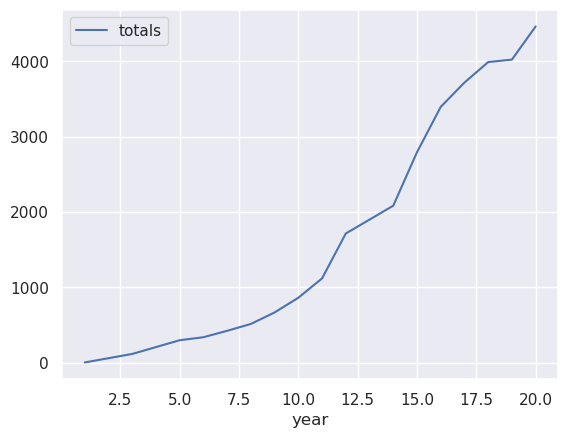

<Figure size 640x480 with 0 Axes>

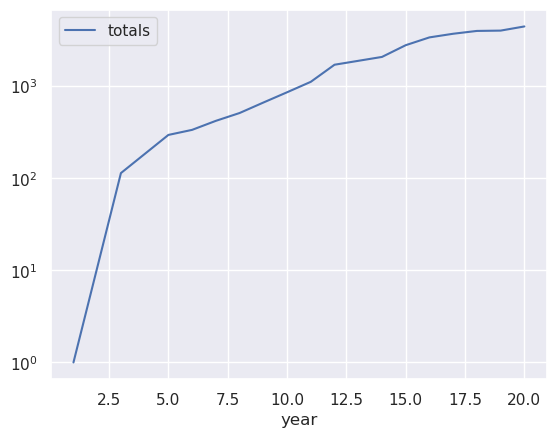

In [3]:
# Turbines in Oklahoma from 2000 on
ok_filter = (turbines.t_state == 'OK') & (turbines.year >= 0)
ok_turbines = turbines[ok_filter].sort_values('year')
ok_turbines["totals"] = np.cumsum(ok_turbines["t_built"])
# Log-transform the counts, too
ok_turbines["log_totals"] = np.log(ok_turbines["totals"])

plt.figure()
ok_turbines.plot('year', 'totals')

plt.figure()
ok_turbines.plot('year', 'totals')
plt.semilogy();

Recall our problem setup:

* $X$: an $n \times d$ matrix, where each row is a data point, and each column is a feature (fixed)
* $\beta$: a $d$-dimensional vector with one coefficient for each feature (random, unknown: this is what we want)
* $y$: an $n$-dimensional vector, with a number (response variable / dependent variable) that we want to predict for each data point (random, because it depends on $\beta$ and on some error, often captured in a noise vector $\epsilon$)

The likelihood $p(y|\beta)$ usually describes the error model: in standard least squares regression, it's

$$
y|\beta \sim N(X\beta, \sigma^2 I_n)
$$

Let's think about the implicit assumptions we're making by choosing this likelihood. Recall that for the normal distribution, we're very unlikely to see values more than 3$\sigma$ away from the mean. That means that we're implicitly assuming that the vast majority of $y$-values we see will be within 3$\sigma$ of the mean (i.e., the prediction $X\beta$).

### Log-transforming data

Log-transforming the $y$ variable is an important preprocessing step in many analyses: above, it turned an exponential-looking relationship into a linear one. We're saying that $\log(y) = X\beta$, or equivalently that $y = \exp(X\beta)$.

### Bayesian model

We're fitting what's called a Generalized Linear Model (GLM) using PyMC3: we'll learn more about GLMs a little later. The code used is adapted from [this tutorial](https://docs.pymc.io/notebooks/GLM-linear.html).

In [4]:
ok_turbines

,t_state,t_built,t_cap,year,totals,log_totals
361,OK,1,100.0,1.0,1,0.000000
362,OK,113,176250.0,3.0,114,4.736198
363,OK,182,298200.0,5.0,296,5.690359
364,OK,40,60000.0,6.0,336,5.817111
365,OK,85,154500.0,7.0,421,6.042633
366,OK,91,141900.0,8.0,512,6.238325
367,OK,153,299100.0,9.0,665,6.499787
368,OK,195,352260.0,10.0,860,6.756932
369,OK,257,524900.0,11.0,1117,7.018402
370,OK,596,1127050.0,12.0,1713,7.446001


In [6]:
gaussian_model = bmb.Model(formula='log_totals ~ year', data=ok_turbines)
gaussian_trace = gaussian_model.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_totals_sigma, Intercept, year]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


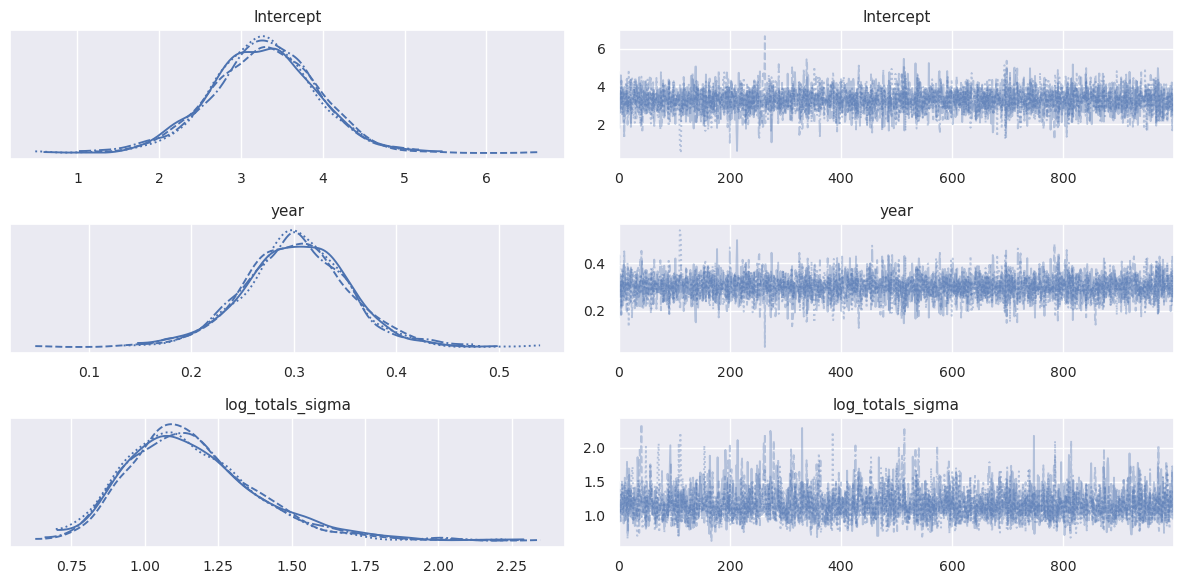

In [16]:
az.plot_trace(gaussian_trace)
plt.tight_layout()

The plots on the left show histograms of the samples for each hidden variable (in this case, the hidden variables are the regression intercept, the regression slope (coefficient of x), and the standard deviation of the errors. The plots on the right show how those variables changed from sample to sample.

The mean of the coefficient for `year` is around 0.3. What does this mean? It means that for every unit increase in `year` (i.e., every year), we see a linear increase of about 0.3 in `log_totals`. But we're not really interested in `log_totals`!

We're really interested in how `year` affects the turbine count (rather than the log). Let $N_{t}$ be the number of turbines in year $t$, and let $y_t = \log(N_t)$ be what we're predicting in the regression above. Then we have:

$$
y_{t+1} = y_t + 0.3 \\
\log(N_{t+1}) = \log(N_t) + 0.3 \\
N_{t+1} = N_t e^{0.3}
$$

In other words, every year, this regression tells us that the prediction is $e^{0.4}$ times the value from the previous year. That's the effect that log-transforming the data has on the output: instead of predicting an additive increase, we're predicting a multiplicative increase.

In [17]:
np.exp(0.3)

1.3498588075760032

That's an increase of about $49\%$ every year.

In [19]:
# From the graph above, it looks like the coefficient could 
# reasonably be between 0.25 and 0.35. How does that affect
# the year-over-year change?
(np.exp(0.25), np.exp(0.35))

(1.2840254166877414, 1.4190675485932573)

## Count regression

The regression model above works reasonably well, but it doesn't account for the fact that the variable we're predicting is a whole number (meaning that it takes values $0, 1, 2, 3, \ldots$). When we say that $y|\beta \sim N(X\beta, \sigma^2 I)$, and using log-transformed data for $y$, we're implicitly saying that $y$ can never be 0. Can we use a different likelihood that is designed specifically for this kind of data?

We've already seen one different model for the case where $y$ is binary: logistic regression. In this section, we'll explore two models for predicting count data: Poisson regression and negative binomial regression.

### Poisson regression

Recall that the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is a distribution over counts and count-like values. It has one *positive* parameter $\lambda$ that represents its mean (and variance, too).

In Poisson regression, we're going to assume a Poisson likelihood for each $y_i$. The parameter of the distribution must be positive, but $x_i^T\beta$ could be negative. There are several ways to make the possibly-negative value into a positive one, but we'll use $\exp(x_i^T \beta)$ as the mean. This way, we don't have to log-transform the data. We can write out our likelihood:

$$
y_i | \beta \sim \text{Poisson}(\exp(x_i^T \beta))
$$

Let's try it out in PyMC3! Even though the different likelihood means that we're optimizing a completely different loss function, we only need to make a few tiny changes to our code from earlier:

In [36]:
poisson_model = bmb.Model(formula='totals ~ year', data=ok_turbines, family='poisson')
poisson_trace = poisson_model.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, year]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


One consequence of the Poisson likelihood is that $E[y|\beta] = exp(x_i^T \beta)$, which means that our interpretation of the coefficient(s) is the same as it was in the earlier case.

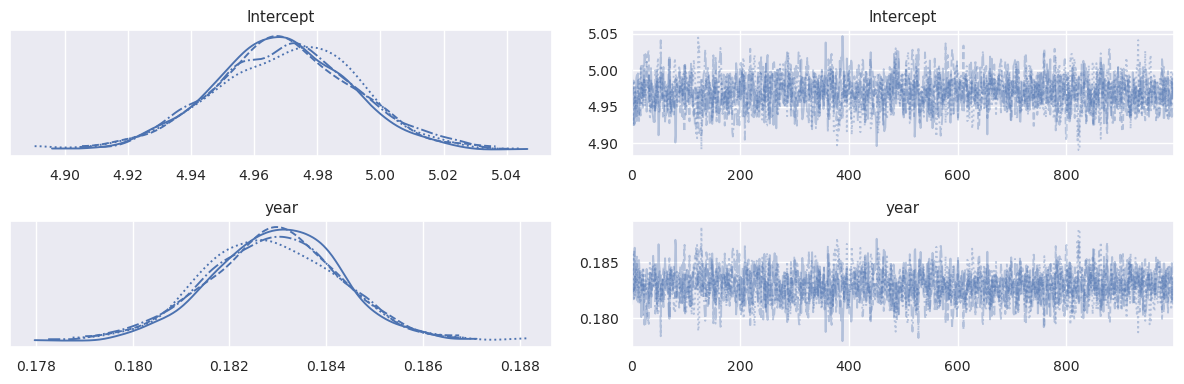

In [37]:
az.plot_trace(poisson_trace)
plt.tight_layout()

Comparing this to the results from the Gaussian model, we can see that the posteriors are **much** narrower. On top of that, the values of the coefficient for `year` seem much smaller: whereas before we saw values around $0.3$, now it looks like the values are around 0.183.

In [38]:
np.exp(0.183)

1.2008144080808307

This corresponds to only a $22.5\%$ average growth rate, compared to our $35\%$ average growth rate from the earlier model. Why are the results so different? Let's think about the implicit assumptions we're making when choosing a Poisson likelihood. The Poisson distribution's mean is equal to its variance. 

Clearly, the Poisson is a poor choice for fitting this data! When the model assumes a lower variance than is actually present in the data, we say that the data are **overdispersed** (i.e., that they're too spread out relative to the model's assumptions). We should choose a different distribution that gives us the ability to control the variance as well as the mean.

(Note that this wasn't a problem with the normal likelihood earlier: because the normal distribution has two separate parameters for mean and variance, we can choose them separately to reflect the fact that the variance may be higher than the mean.)

### Negative binomial regression

The [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution) is also a distribution over counts, but it's more sophisticated than the Poisson distribution. We can think of it one of two ways:
* It's the sum of $r$ [Geometric random variables], each with parameter $p$ (success probability).
* It's like a Poisson distribution if the mean parameter ($\lambda$ above) were also random.

There are several different ways to parametrize the negative binomial. How do we choose which one to use? There are two answers:

1. We want a parametrization that lets us choose the mean, since we want the mean value for $y_i$ to be $\exp(x_i^T \beta)$.
2. Since we're using PyMC3, we're limited to whichever parametrization(s) it supports.

Even though the form of the distribution is significantly more complex and manipulating it involves more work, using it in our regression model requires only a tiny change to what we were doing before:

In [40]:
negbin_model = bmb.Model(formula='totals ~ year', data=ok_turbines, family='negativebinomial')
negbin_trace = negbin_model.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [totals_alpha, Intercept, year]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


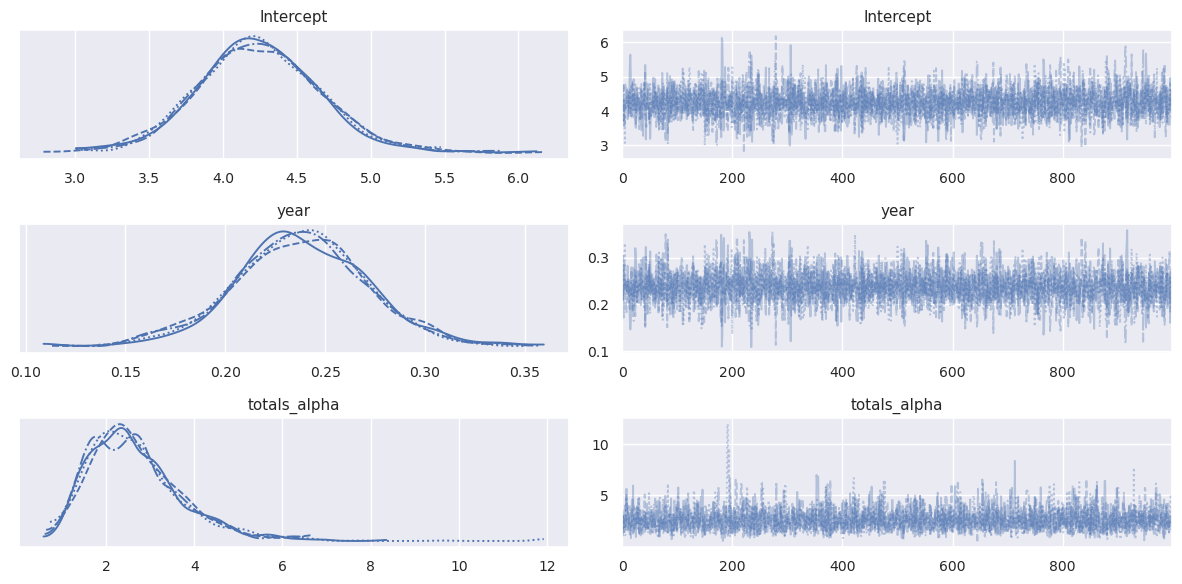

In [42]:
az.plot_trace(negbin_trace)
plt.tight_layout()

Here, the posterior distribution for the $x$ coefficient has a wider spread again. It looks like the mean is around $0.24$:

In [43]:
np.exp(0.24)

1.2712491503214047

This corresponds to a growth rate around $27\%$.

### What happened to the priors?

You may have noticed that I claimed we're doing "Bayesian inference", but there were no priors used above! By default, PyMC3 uses a "flat" prior, which is uniform over all real numbers. This is what's called an "improper" prior, because it doesn't and can't integrate to 1 (or to any finite number).

You can specify priors for $\beta$: can you find out how using the documentation?

## Generalized Linear Models

By now, you've seen four different versions of regression in the Bayesian setting:

* Linear regression, for predicting real-valued outputs
* Logistic regression, for predicting binary outputs (classification)
* Poisson regression, for predicting counts
* Negative binomial regression, for predicting counts

Let's review what they had in common and what was different between them:

1. For all four, computing our prediction for $y_i$ begins with computing $x_i^T \beta$. This part is a *linear* function of $x_i$, even if we do something nonlinear with it later.
   
2. Each one had a different function that we used to compute the average value of $y_i$ from $x_i^T \beta$. Since this function links the linearly transformed input $x$ to the output $y$, you might expect us to call it the **link function**: this would make a lot of sense. However, the convention is to do the opposite, and call it the **inverse link function**. As you might expect from this name, the **link function** is the inverse of the inverse link function.

3. For each one, we used a different distribution for the likelihood. In all cases, the output of the function above was always the mean of this distribution.

The following table summarizes the different choices of likelihood and link function for the four versions that we've seen:

| Regression | Inverse link function | Link function | Likelihood |
| :-- | :-- | :-- | :-- |
| Linear | identity | identity | Gaussian |
| Logistic | sigmoid | [logit](https://en.wikipedia.org/wiki/Logit) | Bernoulli |
| Poisson | exponential | log | Poisson |
| Negative binomial | exponential | log | Negative binomial |
   
These ideas form the basis for what are known as Generalized Linear Models, or GLMs. Once we choose a link function and a likelihood distribution, our model is fully specified, and we can approximate the posterior distribution over the coefficients in $\beta$.

### Frequentist GLMs

We'll look at the same models we implemented before, but this time we'll use the `statsmodels` package to look at things through a frequentist lens.

In [44]:
gaussian_model = sm.GLM(
    np.log(ok_turbines.totals), ok_turbines.year, 
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       16
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          3.3610
Method:                          IRLS   Log-Likelihood:                -33.911
Date:                Thu, 15 Feb 2024   Deviance:                       53.776
Time:                        19:59:26   Pearson chi2:                     53.8
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2027
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.5346      0.035     15.098      0.0

This model's results don't look like the others, because it's missing an intercept. We need to use the `add_constant` function in `statsmodels`:

In [46]:
gaussian_model_intercept = sm.GLM(
    np.log(ok_turbines.totals), sm.add_constant(ok_turbines.year),
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model_intercept.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.1810
Method:                          IRLS   Log-Likelihood:                -24.472
Date:                Thu, 15 Feb 2024   Deviance:                       17.716
Time:                        19:59:32   Pearson chi2:                     17.7
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9131
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2602      0.590      5.526      0.0

Take a minute to look over the results. What does it mean that the standard error for the estimated `year` coefficient is 0.047?

In [47]:
poisson_model = sm.GLM(
    ok_turbines.totals, sm.add_constant(ok_turbines.year),
    family=sm.families.Poisson()
)
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -755.42
Date:                Thu, 15 Feb 2024   Deviance:                       1366.3
Time:                        19:59:33   Pearson chi2:                 1.20e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9697      0.023    219.386      0.0

The coefficients on `p_year` looks similar to what we got with the Bayesian approach. Notice that the standard error is extremely small: we have the same problem with overconfidence!

Note that in addition to the coefficients at the bottom, we also get goodness of fit measures such as log-likelihood, deviance, and chi-squared: we'll talk a little more about these and what they mean later.

For now, let's try the negative binomial model:

In [25]:
negbin_model = sm.GLM(
    ok_turbines.totals, sm.add_constant(ok_turbines.year),
    family=sm.families.NegativeBinomial()
)
negbin_results = negbin_model.fit()
print(negbin_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.14
Date:                Wed, 17 Feb 2021   Deviance:                       7.1483
Time:                        12:51:51   Pearson chi2:                     1.90
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2059      0.544      7.725      0.0